# QAOA On MaxCut with TFQ
Defined below are 2 key functions that can be used with any unweighted maxcut graph of any depth to provide the TFQ model components for parameter optimization or visualization of the QAOA PQC against the physical MaxCut network

### Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
#supress warning for matplotlib
import warnings
warnings.filterwarnings("ignore")
import networkx as nx

### Function: maxcut_qaoa_TFQ_model
This function allows the process of constructing a TFQ model given any MaxCut instance to be streamlined as it returns the two components needed for the model: the model architecture layers, the model input, and parameter names. All that needs to be done after is to use the returned values to compile and fit the model with the desired hyperparameters

In [2]:
def maxcut_qaoa_TFQ_model(graph, depth_tot):
    """Takes in a udR, n-node MaxCut graph, maps it to a QAOA circuit (assuming full connectivity), 
    and creates TFQ model for it  """
    
    # Map nodes to qubits 1:1, crearte variables for circuit & total params
    qubits = cirq.GridQubit.rect(1, len(graph.nodes))
    qaoa_circuit = cirq.Circuit()
    qaoa_params = []
    
    # Create a parameter set
    for depth in range(depth_tot):
        qaoa_params.append(sympy.Symbol("gamma_{}".format(depth)))
    
        # Create {H_C, H_M} alternating depth_tot times 
        for edge in graph.edges():
            qaoa_circuit += cirq.ZZ(qubits[edge[0]], qubits[edge[1]])**qaoa_params[-1]
            
        qaoa_params.append(sympy.Symbol("beta_{}".format(depth)))
        for node in graph.nodes():
            qaoa_circuit += cirq.X(qubits[node])**qaoa_params[-1]
            
    # Define the H_c to pass into tfq.layers.PQC as measurement operator?
    cost_op = None
    for edge in graph.edges():
        if cost_op is None:
            cost_op = cirq.Z(qubits[edge[0]])*cirq.Z(qubits[edge[1]])
        else:
            cost_op += cirq.Z(qubits[edge[0]])*cirq.Z(qubits[edge[1]])
        
    """Use qaoa_circuit, cost_op, hadamard_circuit for model to create the TFQ model"""
    
    # Input will be initial superposition (hadamard transform)
    hadamard_transform = cirq.Circuit()
    for q in qubits:
        hadamard_transform += cirq.H(q)
    model_input = tfq.convert_to_tensor([hadamard_transform])
    
    # Construct model layers/architecture
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string),
        tfq.layers.PQC(qaoa_circuit, cost_op)])
    
    # Provide elements needed to train/fit model
    return model, model_input, qaoa_params

In [3]:
# Test out the TFQ model function
graph_a = nx.random_regular_graph(d=4, n=6)
model, model_input, qaoa_params = maxcut_qaoa_TFQ_model(graph_a, 3)

# Total params to optimize in the summary agrees with our desired depth (p=3)
model.summary()
print(model_input)
qaoa_params

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
tf.Tensor([b'\n\x0e\n\x0ctfq_gate_set\x12\x9b\x04\x08\x01\x12\x96\x04\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_0\nW\n\x04\n\x02HP\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x1a\x05\x12\x030_1\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\

[gamma_0, beta_0, gamma_1, beta_1, gamma_2, beta_2]

### Function: QAOA_circuit_vis
Along with this TFQ model function, it would also be useful to visualize the graph, so this function provides a side-by-side comparison of the mapped QAOA circuit ansatz of any MaxCut instance with the physical MaxCut graph itself. This allows for any disagreements between the MaxCut graph structure and the QAOA circuit to be easily identified and fixed.

In [4]:
def QAOA_circuit_vis(graph, depth_tot):
    """Provides the QAOA Circuit ansatz of any depth (assuming full connectivity)
    for a MaxCut instance and the MaxCut graph itself, purely for visualization"""
    
    qubits = cirq.GridQubit.rect(1, len(graph.nodes))
    qaoa_circuit = cirq.Circuit()
    qaoa_params = []
    
    # Initial Hadamard transform 
    for qubit in qubits:
        qaoa_circuit += cirq.H(qubit)
    
    # Create a parameter set
    for depth in range(depth_tot):
        qaoa_params.append(sympy.Symbol("gamma_{}".format(depth)))
    
        # Create {H_C, H_M} alternating depth_tot times 
        for edge in graph.edges():
            qaoa_circuit += cirq.ZZ(qubits[edge[0]], qubits[edge[1]])**qaoa_params[-1]
            
        qaoa_params.append(sympy.Symbol("beta_{}".format(depth)))
        cost_ham = cirq.Moment([])
        for node in graph.nodes():
            cost_ham += (cirq.X(qubits[node])**qaoa_params[-1])
        qaoa_circuit.append(cost_ham)
    
    # Draw physical graph w/ nodes relabelled to agree with QAOA circuit 
    sorted(graph)
    mapping = {}
    for node in sorted(graph.nodes()):
        mapping[node] = '(0,' + str(node) + ')'
    graph_new = nx.relabel_nodes(graph, mapping)
    plt.figure()
    plt.title('{}-node, regular MaxCut Graph'.format(len(graph.nodes())))
    graph_plot = nx.draw_networkx(graph_new, node_size=800)
    print(graph_plot)
    
    return SVGCircuit(qaoa_circuit)

None


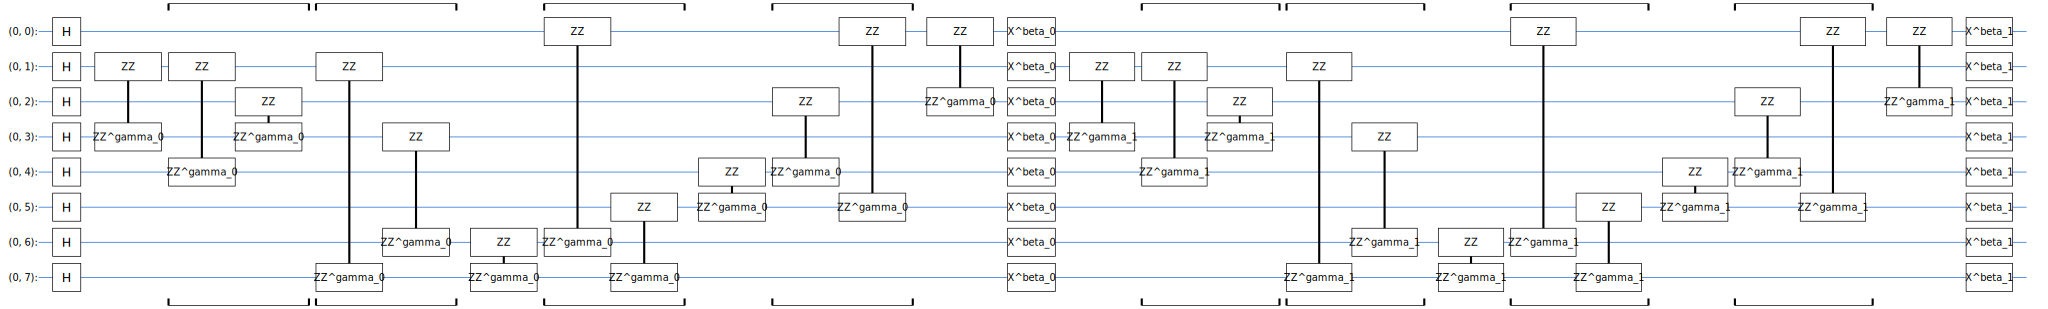

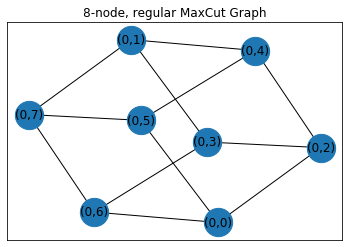

In [5]:
# Testing out the visualization function
graph_b = nx.random_regular_graph(n=8, d=3)
QAOA_circuit_vis(graph_b, 2)

## Graph 1: 4 node, u3R (Toy Model)
1. Goal: optimize parameters of a 4-node u3R MaxCut graph instance to extract the optimal parameters that provide the __exact/approx answer of__
2. Frist with p=1, then sweeping through to p=5

None


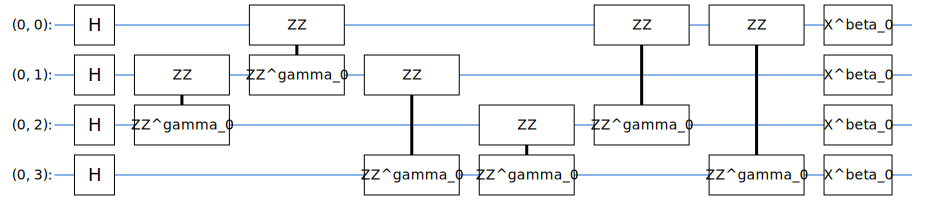

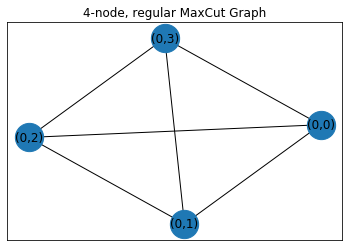

In [6]:
# Create the graph
graph_1 = nx.random_regular_graph(n=4, d=3)

# Visualize graph_1 mapped to QAOA circuit for p=1
QAOA_circuit_vis(graph_1, 1)

In [7]:
# Create the TFQ model components for graph_1 at p=1 depth
model, model_input, graph_1_params = maxcut_qaoa_TFQ_model(graph_1, 1)
model.summary()
print(model_input)
graph_1_params

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
tf.Tensor([b'\n\x0e\n\x0ctfq_gate_set\x12\xe9\x02\x08\x01\x12\xe4\x02\nW\n\x04\n\x02HP\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x1a\x05\x12\x030_0\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_1\nW\n\x04\n\x02HP\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00

[gamma_0, beta_0]

In [8]:
# Define optimum for loss
optimum = [0]
optimum = np.array(optimum)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.mean_squared_error)

# Create an early stopping mechanism
#callback_strat = tf.keras.callbacks.EarlyStopping(
#    monitor='loss', min_delta=0.003, patience=0, verbose=1)
#print(callback_strat)

**NOTE: Currently Trying to Fix this Error during Training Below (Either Dead Kernel or other Error)**

In [ ]:
# Train the model
history = model.fit(model_input, optimum, epochs=20, verbose=1)

Train on 1 samples
Epoch 1/20


In [ ]:
# View performance
plt.plot(history.history['loss'])
plt.title("QAOA Parameter Optimization with TFQ")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.show()

In [ ]:
# Use the model for prediction (model.predict())
# Read out the optimal parameters
opt_params = model.trainable_variables
opt_params

In [ ]:
# Create a circuit and sample from the final state 1000 times
# Can create circuit in Cirq or TFQ
output_circuit = tfq.layers.AddCircuit(model_input, append=qaoa_circuit)
sample_layer = tfq.layers.Sample()

output = sample_layer(output_circuit,  symbol_names= graph_1_params, symbol_values= params, repetitions=1000)

In [ ]:
# Output has measurement of all 10 qubits, 1000 times using optimal beta, gamma params
# Here's the first 10 reps and the outputs 
for i, element in enumerate(output.values[:10]):
    print(f'\nrep {i} qubit measurements:\n')
    for j, bit in enumerate(element):
        print(f'qubit {j} measurment: {bit}')

In [ ]:
# Store the position of all the 1s in a list for the cut set
all_ones = []
for bitstr in output.values:
    temp_list = []
    for pos, bit in enumerate(bitstr):
        if bit==1:
            temp_list.append(pos)
    all_ones.append(temp_list)

all_ones[:50]

In [ ]:
# Generate a list with all possible subsets- combinatorial total
from itertools import combinations
sub_lists = []
for i in range(0, len(graph_a.nodes())+1):
  temp = [list(x) for x in combinations(graph_a.nodes(), i)]
  sub_lists.extend(temp)

sub_lists[:50]

In [ ]:
# Calculate the cut_size for all possible cuts
cut_size = []
for sub_list in sub_lists:
  cut_size.append(nx.algorithms.cuts.cut_size(graph_a,sub_list))


print("For all possible cuts (first 20):")


print(f'Cut sizes: {cut_size[:20]}\n')
print(f'Corresponding cut set: {sub_lists[:20]}')

# Calculate the cut_size for the cuts found with QAOA
cut_size_qaoa = []
for cut in cuts_qaoa:
  cut_size_qaoa.append(nx.algorithms.cuts.cut_size(graph_a,cut))

# preview the differences between QAOA and all cuts
print("\nFound with QAOA:")
print(f'Cut sizes (QAOA): {cut_size_qaoa[:20]}\n')
print(f'Corresponding QAOA found cut set: {cuts_qaoa[:20]}')

In [ ]:
# Finally, calculate the approximation ratio 
np.mean(cut_size_qaoa)/np.max(cut_size)